In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [2]:
path = os.getcwd()

In [3]:
train_start_time = '2019-01-01 00:00:00'
train_end_time = '2019-09-10 21:59:59'
test_start_time = '2019-09-10 22:00:00'
test_end_time = '2020-01-01 00:00:00'

In [4]:
prod = 'BTCUSD'
price = pd.read_csv(path + '/clean_data/hourly%s-H1.csv' % prod, sep='\t')
price['ds'] = pd.to_datetime(price['Date'].astype(str) + ' ' + price['Time'], format='%Y%m%d %H:%M:%S')
price.index = pd.DatetimeIndex(price['ds'])

data = pd.read_csv(path + '/result/%s-forecast_df.csv' % prod)
data['ds'] = pd.to_datetime(data['ds'], format='%Y-%m-%d %H:%M:%S')
data.index = pd.DatetimeIndex(data['ds'])

In [5]:
price.head()

,Date,Time,Open,High,Low,Close,Volume,ds
ds,,,,,,,,
2017-05-08 00:00:00,20170508,00:00:00,1555.1,1614.5,1544.2,1593.3,252,2017-05-08 00:00:00
2017-05-08 01:00:00,20170508,01:00:00,1593.3,1627.5,1556.3,1593.4,296,2017-05-08 01:00:00
2017-05-08 02:00:00,20170508,02:00:00,1594.2,1623.5,1574.0,1594.8,292,2017-05-08 02:00:00
2017-05-08 09:00:00,20170508,09:00:00,1620.3,1637.1,1593.9,1606.2,248,2017-05-08 09:00:00
2017-05-08 10:00:00,20170508,10:00:00,1608.1,1625.7,1598.3,1610.0,240,2017-05-08 10:00:00


In [6]:
data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,
2019-01-01 22:00:00,2019-01-01 22:00:00,0.000275,-0.010682,0.011728,0.000275,0.000275,0.000013,0.000013,0.000013,0.000248,0.000248,0.000248,-0.000235,-0.000235,-0.000235,0.0,0.0,0.0,0.000288
2019-01-01 23:00:00,2019-01-01 23:00:00,0.000276,-0.011904,0.011900,0.000276,0.000276,0.000016,0.000016,0.000016,0.000247,0.000247,0.000247,-0.000230,-0.000230,-0.000230,0.0,0.0,0.0,0.000292
2019-01-02 00:00:00,2019-01-02 00:00:00,0.000276,-0.011931,0.011454,0.000276,0.000276,-0.000045,-0.000045,-0.000045,0.000183,0.000183,0.000183,-0.000228,-0.000228,-0.000228,0.0,0.0,0.0,0.000230
2019-01-02 01:00:00,2019-01-02 01:00:00,0.000276,-0.011586,0.011698,0.000276,0.000276,-0.000162,-0.000162,-0.000162,0.000067,0.000067,0.000067,-0.000229,-0.000229,-0.000229,0.0,0.0,0.0,0.000114
2019-01-02 02:00:00,2019-01-02 02:00:00,0.000276,-0.011385,0.011999,0.000276,0.000276,-0.000342,-0.000342,-0.000342,-0.000109,-0.000109,-0.000109,-0.000233,-0.000233,-0.000233,0.0,0.0,0.0,-0.000066


In [7]:
data['pred_larger_than_zero'] = data['yhat'] > 0
data['pred_smaller_than_zero'] = data['yhat'] < 0

In [8]:
periods = 3

data['strategy'] = 0
data['strategy'].loc[data['pred_larger_than_zero'].cumsum().diff(periods=periods).fillna(method='bfill') == periods] = 1
data['strategy'].loc[data['pred_smaller_than_zero'].cumsum().diff(periods=periods).fillna(method='bfill') == periods] = -1

In [9]:
data['strategy']

ds
2019-01-01 22:00:00    1
2019-01-01 23:00:00    1
2019-01-02 00:00:00    1
2019-01-02 01:00:00    1
2019-01-02 02:00:00    0
                      ..
2019-12-31 18:00:00   -1
2019-12-31 19:00:00   -1
2019-12-31 20:00:00   -1
2019-12-31 21:00:00   -1
2019-12-31 22:00:00   -1
Name: strategy, Length: 6216, dtype: int64

In [10]:
data = pd.concat([price, data], axis=1).dropna(axis=0)

In [11]:
data

,Date,Time,Open,High,Low,Close,Volume,ds,ds,trend,...,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,pred_larger_than_zero,pred_smaller_than_zero,strategy
ds,,,,,,,,,,,,,,,,,,,,,
2019-01-01 22:00:00,20190101,22:00:00,3658.6,3662.5,3649.9,3658.0,240,2019-01-01 22:00:00,2019-01-01 22:00:00,0.000275,...,-0.000235,-0.000235,-0.000235,0.0,0.0,0.0,0.000288,True,False,1.0
2019-01-01 23:00:00,20190101,23:00:00,3658.1,3780.4,3656.0,3762.8,240,2019-01-01 23:00:00,2019-01-01 23:00:00,0.000276,...,-0.000230,-0.000230,-0.000230,0.0,0.0,0.0,0.000292,True,False,1.0
2019-01-02 00:00:00,20190102,00:00:00,3763.3,3777.0,3732.4,3741.7,240,2019-01-02 00:00:00,2019-01-02 00:00:00,0.000276,...,-0.000228,-0.000228,-0.000228,0.0,0.0,0.0,0.000230,True,False,1.0
2019-01-02 01:00:00,20190102,01:00:00,3741.7,3748.0,3730.7,3732.8,240,2019-01-02 01:00:00,2019-01-02 01:00:00,0.000276,...,-0.000229,-0.000229,-0.000229,0.0,0.0,0.0,0.000114,True,False,1.0
2019-01-02 02:00:00,20190102,02:00:00,3733.3,3744.6,3732.4,3741.5,240,2019-01-02 02:00:00,2019-01-02 02:00:00,0.000276,...,-0.000233,-0.000233,-0.000233,0.0,0.0,0.0,-0.000066,False,True,0.0
2019-01-02 03:00:00,20190102,03:00:00,3741.6,3750.4,3738.9,3740.2,240,2019-01-02 03:00:00,2019-01-02 03:00:00,0.000276,...,-0.000239,-0.000239,-0.000239,0.0,0.0,0.0,-0.000288,False,True,0.0
2019-01-02 04:00:00,20190102,04:00:00,3740.2,3745.4,3732.0,3740.1,240,2019-01-02 04:00:00,2019-01-02 04:00:00,0.000277,...,-0.000249,-0.000249,-0.000249,0.0,0.0,0.0,-0.000476,False,True,-1.0
2019-01-02 05:00:00,20190102,05:00:00,3740.1,3741.4,3735.1,3739.0,240,2019-01-02 05:00:00,2019-01-02 05:00:00,0.000277,...,-0.000261,-0.000261,-0.000261,0.0,0.0,0.0,-0.000537,False,True,-1.0
2019-01-02 06:00:00,20190102,06:00:00,3738.9,3740.0,3718.1,3719.3,240,2019-01-02 06:00:00,2019-01-02 06:00:00,0.000277,...,-0.000276,-0.000276,-0.000276,0.0,0.0,0.0,-0.000442,False,True,-1.0


In [12]:
useCols = ['Open', 'yhat', 'strategy']

train = data.loc[train_start_time: train_end_time, useCols]
test = data.loc[test_start_time: test_end_time, useCols]

In [13]:
base = 10000
tmp = train
hold = 0
deposit = 10000
returnList = []
previousPrice = 0
numTrade = 0

for date, s in tmp.iterrows():
    p, yhat, strategy = s
    
    if strategy == 1:
        
        if hold in [0]:
            print('%s: 買進 - 現價 %.f' % (date, p))
            # buy one unit
            deposit -= p
            previousPrice = p
        hold = 1
        
        
    elif strategy == -1:
        if hold in [0]:
            print('%s: 買空 - 現價 %.2f' % (date, p))
            # sell one unit
            deposit += p
            previousPrice = p
        hold = -1
    
    else:
        if hold == 1:
            print('%s: 賣出 - 現價 %.2f - 損益 %.5f' % (date, p, p - previousPrice))
            # sell one unit
            returnList.append(p - previousPrice)
            deposit += p
            numTrade += 1

        elif hold == -1:
            print('%s: 回補 - 現價 %.2f - 損益 %.5f' % (date, p, previousPrice - p))
            # buy one unit
            returnList.append(previousPrice - p)
            deposit -= p
            numTrade += 1
        hold = 0
        
    
if hold == 1:
    # sell one unit
    returnList.append(p - previousPrice)
    deposit += p
elif hold == -1:
    # buy one unit
    returnList.append(previousPrice - p)
    deposit -= p
    
print('number of trade: ', numTrade)

2019-01-01 22:00:00: 買進 - 現價 3659
2019-01-02 02:00:00: 賣出 - 現價 3733.30 - 損益 74.70000
2019-01-02 04:00:00: 買空 - 現價 3740.20
2019-01-02 13:00:00: 回補 - 現價 3753.60 - 損益 -13.40000
2019-01-02 15:00:00: 買進 - 現價 3772
2019-01-02 17:00:00: 賣出 - 現價 3791.30 - 損益 19.00000
2019-01-02 19:00:00: 買空 - 現價 3789.00
2019-01-04 08:00:00: 回補 - 現價 3746.10 - 損益 42.90000
2019-01-04 10:00:00: 買進 - 現價 3724
2019-01-07 18:00:00: 賣出 - 現價 3956.60 - 損益 232.40000
2019-01-07 20:00:00: 買空 - 現價 3964.10
2019-01-07 21:00:00: 回補 - 現價 3947.60 - 損益 16.50000
2019-01-07 23:00:00: 買進 - 現價 3939
2019-01-08 01:00:00: 賣出 - 現價 3955.20 - 損益 16.60000
2019-01-08 03:00:00: 買空 - 現價 3923.90
2019-01-08 12:00:00: 回補 - 現價 3974.40 - 損益 -50.50000
2019-01-08 14:00:00: 買進 - 現價 4003
2019-01-08 18:00:00: 賣出 - 現價 3944.10 - 損益 -58.70000
2019-01-08 22:00:00: 買進 - 現價 3939
2019-01-09 02:00:00: 賣出 - 現價 3957.60 - 損益 18.20000
2019-01-09 04:00:00: 買空 - 現價 3959.60
2019-01-09 12:00:00: 回補 - 現價 3967.50 - 損益 -7.90000
2019-01-09 14:00:00: 買進 - 現價 3948
2019-01-09 1

2019-05-02 02:00:00: 賣出 - 現價 5258.50 - 損益 168.30000
2019-05-02 04:00:00: 買空 - 現價 5275.50
2019-05-02 12:00:00: 回補 - 現價 5310.80 - 損益 -35.30000
2019-05-02 14:00:00: 買進 - 現價 5316
2019-05-02 17:00:00: 賣出 - 現價 5320.40 - 損益 4.70000
2019-05-02 19:00:00: 買空 - 現價 5329.40
2019-05-02 20:00:00: 回補 - 現價 5341.90 - 損益 -12.50000
2019-05-02 22:00:00: 買進 - 現價 5345
2019-05-07 04:00:00: 賣出 - 現價 5829.60 - 損益 484.40000
2019-05-07 08:00:00: 買進 - 現價 5820
2019-05-09 02:00:00: 賣出 - 現價 5992.70 - 損益 172.60000
2019-05-09 04:00:00: 買空 - 現價 5975.90
2019-05-09 12:00:00: 回補 - 現價 5975.40 - 損益 0.50000
2019-05-09 14:00:00: 買進 - 現價 5953
2019-05-09 18:00:00: 賣出 - 現價 5996.30 - 損益 43.70000
2019-05-09 22:00:00: 買進 - 現價 6058
2019-05-14 04:00:00: 賣出 - 現價 7906.80 - 損益 1848.60000
2019-05-14 08:00:00: 買進 - 現價 8266
2019-05-16 02:00:00: 賣出 - 現價 8265.10 - 損益 -0.60000
2019-05-16 04:00:00: 買空 - 現價 8188.30
2019-05-16 12:00:00: 回補 - 現價 7805.20 - 損益 383.10000
2019-05-16 14:00:00: 買進 - 現價 7801
2019-05-16 17:00:00: 賣出 - 現價 7863.90 - 損益 63.00

Return:  13323.599999999997
Deposit:  23323.59999999998


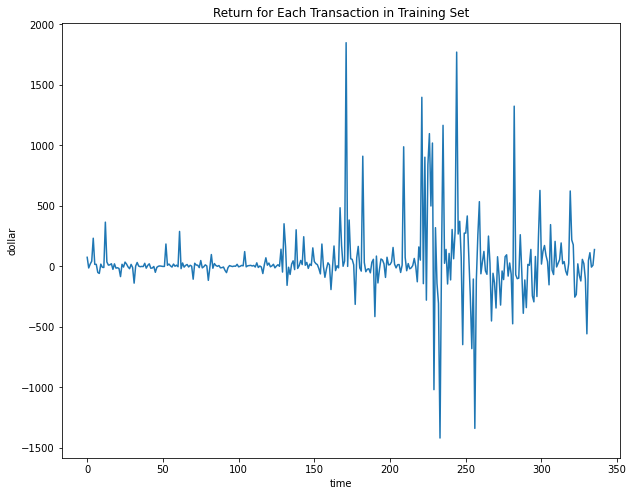

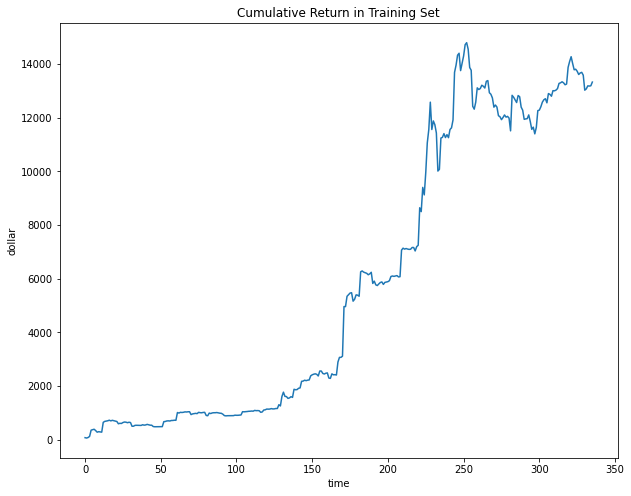

In [14]:
print('Return: ', sum(returnList))
print('Deposit: ', deposit)

plt.figure(figsize=(10, 8))
plt.plot(returnList)
plt.title('Return for Each Transaction in Training Set')
plt.xlabel('time')
plt.ylabel('dollar')
plt.show()


plt.figure(figsize=(10, 8))
plt.plot(pd.Series(returnList).cumsum())
plt.title('Cumulative Return in Training Set')
plt.xlabel('time')
plt.ylabel('dollar')
plt.show()

In [15]:
base = 10000
tmp = test
hold = 0
deposit = 10000
returnList = []
previousPrice = 0
numTrade = 0

for date, s in tmp.iterrows():
    p, yhat, strategy = s
    
    if strategy == 1:
        
        if hold in [0]:
            print('%s: 買進 - 現價 %.f' % (date, p))
            # buy one unit
            deposit -= p
            previousPrice = p
        hold = 1
        
        
    elif strategy == -1:
        if hold in [0]:
            print('%s: 買空 - 現價 %.2f' % (date, p))
            # sell one unit
            deposit += p
            previousPrice = p
        hold = -1
    
    else:
        if hold == 1:
            print('%s: 賣出 - 現價 %.2f - 損益 %.5f' % (date, p, p - previousPrice))
            # sell one unit
            returnList.append(p - previousPrice)
            deposit += p
            numTrade += 1
            
        elif hold == -1:
            print('%s: 回補 - 現價 %.2f - 損益 %.5f' % (date, p, previousPrice - p))
            # buy one unit
            returnList.append(previousPrice - p)
            deposit -= p
            numTrade += 1
            
        hold = 0
        
    
if hold == 1:
    # sell one unit
    returnList.append(p - previousPrice)
    deposit += p
elif hold == -1:
    # buy one unit
    returnList.append(previousPrice - p)
    deposit -= p
    
print('number of trade: ', numTrade)

2019-09-10 23:00:00: 買進 - 現價 10022
2019-09-11 01:00:00: 賣出 - 現價 10081.30 - 損益 59.30000
2019-09-11 03:00:00: 買空 - 現價 10007.60
2019-09-11 13:00:00: 回補 - 現價 10032.20 - 損益 -24.60000
2019-09-11 15:00:00: 買進 - 現價 9964
2019-09-11 16:00:00: 賣出 - 現價 9922.70 - 損益 -40.90000
2019-09-11 18:00:00: 買空 - 現價 9988.40
2019-09-13 11:00:00: 回補 - 現價 10234.10 - 損益 -245.70000
2019-09-13 13:00:00: 買進 - 現價 10286
2019-09-16 04:00:00: 賣出 - 現價 10258.60 - 損益 -27.70000
2019-09-16 06:00:00: 買空 - 現價 10268.30
2019-09-16 07:00:00: 回補 - 現價 10253.80 - 損益 14.50000
2019-09-16 09:00:00: 買進 - 現價 10247
2019-09-16 17:00:00: 賣出 - 現價 10088.50 - 損益 -158.10000
2019-09-16 19:00:00: 買空 - 現價 10070.00
2019-09-17 13:00:00: 回補 - 現價 10159.50 - 損益 -89.50000
2019-09-17 15:00:00: 買進 - 現價 10160
2019-09-17 17:00:00: 賣出 - 現價 10201.10 - 損益 41.20000
2019-09-17 19:00:00: 買空 - 現價 10175.90
2019-09-17 22:00:00: 回補 - 現價 10158.10 - 損益 17.80000
2019-09-18 00:00:00: 買進 - 現價 10131
2019-09-18 01:00:00: 賣出 - 現價 10158.10 - 損益 26.80000
2019-09-18 03:00:00: 買空

Return:  4168.299999999991
Deposit:  14168.3


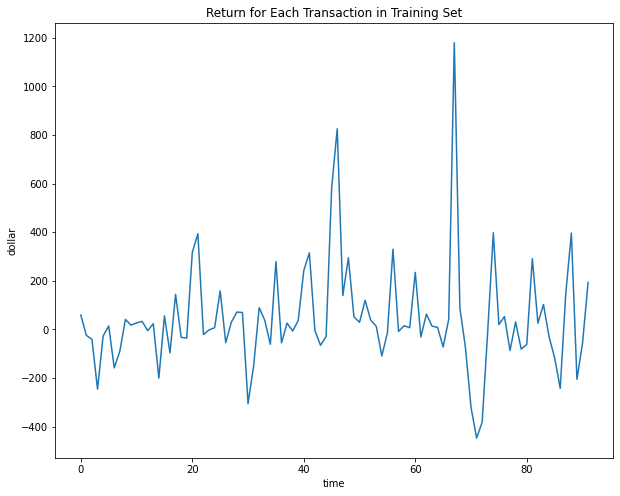

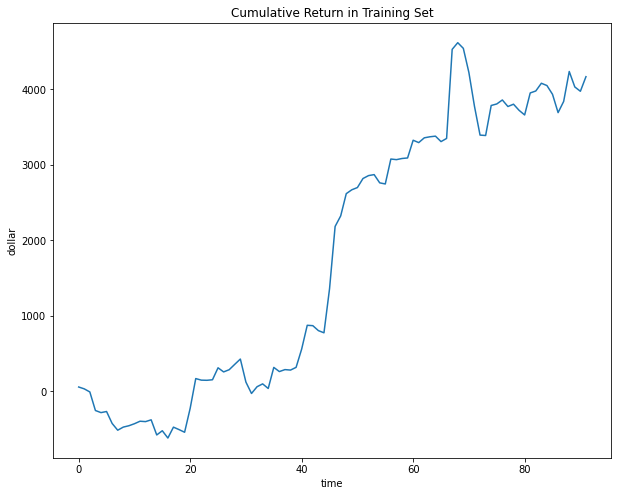

In [16]:
print('Return: ', sum(returnList))
print('Deposit: ', deposit)

plt.figure(figsize=(10, 8))
plt.plot(returnList)
plt.title('Return for Each Transaction in Training Set')
plt.xlabel('time')
plt.ylabel('dollar')
plt.show()


plt.figure(figsize=(10, 8))
plt.plot(pd.Series(returnList).cumsum())
plt.title('Cumulative Return in Training Set')
plt.xlabel('time')
plt.ylabel('dollar')
plt.show()

In [17]:
# periods == 3: 13323.599999999997 / trading times: 336 -> 4168.299999999991 / 91
# periods == 5: 10737.799999999981 / trading times: 239 -> 2062.5999999999967 / 61
# periods == 8: 9634.999999999993 / trading times: 146 -> 2896.300000000004 / 45